In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob

from scipy.stats import rankdata
from scipy.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Stacking Approach using GMEAN

In [2]:
ls '../input/'

wnssubmits/


In [3]:
LABELS = ["is_click"]
all_files = glob.glob("../input/wnssubmits/*.csv")
all_files = [i for i in all_files if 'XX' not in i and 'Enet' not in i]
all_files

['../input/wnssubmits/lgbm-0.7522.csv',
 '../input/wnssubmits/etrees-0.7266.csv',
 '../input/wnssubmits/etrees-0.748.csv',
 '../input/wnssubmits/catboost-0.748788740685787.csv',
 '../input/wnssubmits/lgbm-0.743125032485341.csv',
 '../input/wnssubmits/lgbm-0.745541397058515.csv',
 '../input/wnssubmits/lgbm-0.747742591647401.csv',
 '../input/wnssubmits/lgbm-0.747991659378651.csv',
 '../input/wnssubmits/RF-0.733958920288964.csv',
 '../input/wnssubmits/catboost-0.749421438097387.csv',
 '../input/wnssubmits/lgbm-0.747867710652706.csv',
 '../input/wnssubmits/lgbm-0.746373284087978.csv',
 '../input/wnssubmits/lgbm-0.751.csv']

In [4]:
scores = np.zeros(len(all_files))
for i in range(len(all_files)):
    print(i,all_files[i])
    scores[i] = float(all_files[i].replace('_','-').split("-")[1].replace('.csv',''))

0 ../input/wnssubmits/lgbm-0.7522.csv
1 ../input/wnssubmits/etrees-0.7266.csv
2 ../input/wnssubmits/etrees-0.748.csv
3 ../input/wnssubmits/catboost-0.748788740685787.csv
4 ../input/wnssubmits/lgbm-0.743125032485341.csv
5 ../input/wnssubmits/lgbm-0.745541397058515.csv
6 ../input/wnssubmits/lgbm-0.747742591647401.csv
7 ../input/wnssubmits/lgbm-0.747991659378651.csv
8 ../input/wnssubmits/RF-0.733958920288964.csv
9 ../input/wnssubmits/catboost-0.749421438097387.csv
10 ../input/wnssubmits/lgbm-0.747867710652706.csv
11 ../input/wnssubmits/lgbm-0.746373284087978.csv
12 ../input/wnssubmits/lgbm-0.751.csv


In [5]:
top10 = scores.argsort()[-10:][::-1]
for i, f in enumerate(top10):
    print(i,all_files[f])

0 ../input/wnssubmits/lgbm-0.7522.csv
1 ../input/wnssubmits/lgbm-0.751.csv
2 ../input/wnssubmits/catboost-0.749421438097387.csv
3 ../input/wnssubmits/catboost-0.748788740685787.csv
4 ../input/wnssubmits/etrees-0.748.csv
5 ../input/wnssubmits/lgbm-0.747991659378651.csv
6 ../input/wnssubmits/lgbm-0.747867710652706.csv
7 ../input/wnssubmits/lgbm-0.747742591647401.csv
8 ../input/wnssubmits/lgbm-0.746373284087978.csv
9 ../input/wnssubmits/lgbm-0.745541397058515.csv


In [6]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in top10]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
#concat_sub.reset_index(inplace=True)

In [7]:
concat_sub.index

Index(['000109e6bf54b3b20e8547b6026bc355', '0001c82eb924a3dca30593bf7d8f2227',
       '00038787e666dbf59f419128a0ee3a66', '00044057f135cc6526be752ad83115f6',
       '0004bdb4af3099a24adffc7ff08803e7', '0006768c0a91060c1cef5d45fa15addb',
       '000739e6bc947cf2ba6e6d2d16bfc046', '00074ef1e38588f97e05728525be5c3f',
       '000836ac15f2f993ed30500a4e7cbeb0', '00087f0d21618b2bc9aba0ebb402c6ef',
       ...
       'fff7da71d587ade5b8742d23e22067fb', 'fff88759f4925ce1b88e5262ecd6213b',
       'fff8ec6ab53317b8405746af4312e35e', 'fff8f4e27c1cc9ef55901d95f2f39c3b',
       'fffb735d522525d50962c027f8adbb39', 'fffb7471fecd6f11670e97e1699feb8f',
       'fffdef83c6959d9737880153fc466e45', 'fffe85137b9a34cd129f24458dd1ea38',
       'ffff1b67c9bf77f1dd4df612f6f3911d', 'ffff31b8d1dd1486a7fe6914761aa655'],
      dtype='object', length=90675)

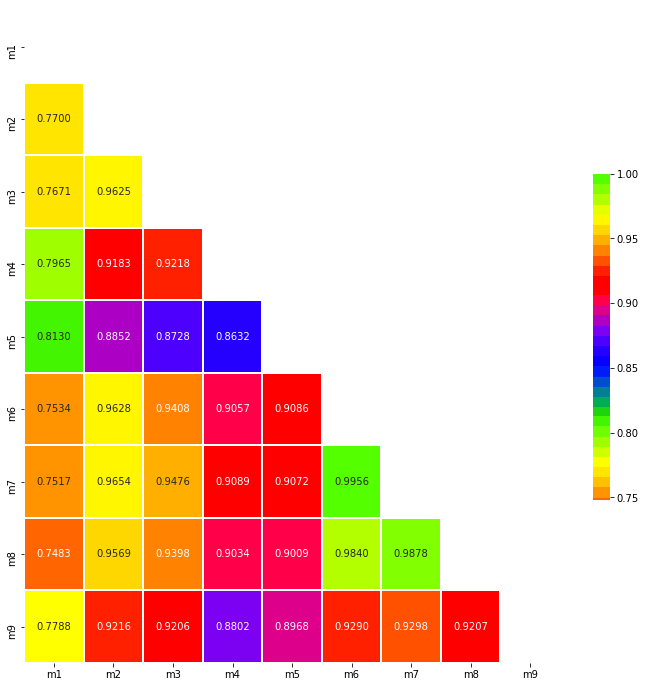

In [8]:
# check correlation
corr = concat_sub.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
            annot=True,fmt='.4f', cbar_kws={"shrink":.5})

# Weighted GMEAN by inverse correlation

In [9]:
rank = np.tril(concat_sub.iloc[:,1:].corr().values,-1)
m = (rank>0).sum() - (rank>0.99).sum()
m_gmean, s = 0, 0
for n in range(min(rank.shape[0],m)):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    w = (m-n)/(m+n/8)
    m_gmean += w*(np.log(concat_sub.iloc[:,mx[0]+1])+np.log(concat_sub.iloc[:,mx[1]+1]))/2
    s += w
    rank[mx] = 1
m_gmean = np.exp(m_gmean/s)

In [10]:
m_gmean = (m_gmean-m_gmean.min())/(m_gmean.max()-m_gmean.min())
describe(m_gmean)

DescribeResult(nobs=90675, minmax=(0.0, 1.0), mean=0.07848760651021566, variance=0.005875112554431172, skewness=2.1268346411627683, kurtosis=8.524899595173867)

In [11]:
m_gmean.values

array([0.06051786, 0.01282095, 0.03108518, ..., 0.11052026, 0.01452852,
       0.07664234])

In [12]:
concat_sub['is_click'] = m_gmean.values
concat_sub['impression_id'] = m_gmean.index
concat_sub[['impression_id','is_click']].to_csv('stack_gmean.csv',index=False)

In [13]:
# out = pd.DataFrame()
# out['is_click'] = m_gmean
# out['impression_id'] = concat_sub.index
# out[['impression_id','is_click']].to_csv('stack_gmean.csv',index=False)

In [14]:
from IPython.display import FileLink, FileLinks
FileLinks('.') #lists all downloadable files on server

./
  stack_gmean.csv
  __notebook__.ipynb
  __output__.json